In [10]:
from tqdm import tqdm
import wandb
import pandas as pd
from typing import Dict, List, Any
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor


def process_run(run_path: str) -> List[Dict[str, Any]]:
    run = wandb.Api().run(run_path)
    config = run.config
    eval_noise = config.get("eval_contexts", {}).get("per_context_features", {}).get("noise")
    context_noise = config.get("contexts", {}).get("per_context_features", {}).get("noise")

    filtered_data = []

    if eval_noise == "range_16_32" and context_noise == "range_0_16":
        history = run.history(samples=500, keys=["_step","eval/episode_completed", "train/episode_completed"], pandas=False)
        for step in history:
            eval_episode_completed = step.get("eval/episode_completed")
            train_episode_completed = step.get("train/episode_completed")

            filtered_run = {
                "id": run.id,
                "name": run.name,
                "step": step.get("_step"),
                "eval_episode_completed": eval_episode_completed,
                "train_episode_completed": train_episode_completed,
                **pd.json_normalize(config, sep=".").to_dict(orient="records")[0],
            }

            filtered_data.append(filtered_run)

    return filtered_data


def fetch_filtered_runs(project_url: str) -> List[Dict[str, Any]]:
    runs = wandb.Api().runs(project_url)
    run_paths = [project_url + "/" + run.id for run in runs]

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(process_run, run_paths), total=len(run_paths)))

    filtered_runs = [run for sublist in results for run in sublist]

    return filtered_runs


def save_runs_to_parquet(runs: List[Dict[str, Any]], output_file: str) -> None:
    runs_df = pd.DataFrame(runs)
    runs_df.to_parquet(output_file, engine="pyarrow", index=False)


project_url = "frederikschubert/carl-smb-ppo"
output_file = "filtered_runs.parquet"

filtered_runs = fetch_filtered_runs(project_url)
save_runs_to_parquet(filtered_runs, output_file)
print(f"Filtered runs saved to {output_file}")

  4%|▍         | 4/91 [00:00<00:06, 13.01it/s]

Found 19 rows for frederikschubert/carl-smb-ppo/jq6p1r3c
Found 28 rows for frederikschubert/carl-smb-ppo/r3z2vwcs
Found 40 rows for frederikschubert/carl-smb-ppo/965imxns
Found 114 rows for frederikschubert/carl-smb-ppo/z7sdx6hf
Found 135 rows for frederikschubert/carl-smb-ppo/dcayjl8g
Found 104 rows for frederikschubert/carl-smb-ppo/xbu6lxh0
Found 105 rows for frederikschubert/carl-smb-ppo/tu6ztn3j
Found 75 rows for frederikschubert/carl-smb-ppo/roi9lj0e
Found 138 rows for frederikschubert/carl-smb-ppo/9akiu3nc
Found 69 rows for frederikschubert/carl-smb-ppo/qzedneba
Found 130 rows for frederikschubert/carl-smb-ppo/tb38t5co
Found 162 rows for frederikschubert/carl-smb-ppo/q5fnfx8s
Found 198 rows for frederikschubert/carl-smb-ppo/fn92gnpo
Found 217 rows for frederikschubert/carl-smb-ppo/qlomd7i6
Found 222 rows for frederikschubert/carl-smb-ppo/hnvb8cr3


  8%|▊         | 7/91 [00:10<02:34,  1.84s/it]

Found 197 rows for frederikschubert/carl-smb-ppo/mkzwiqmk
Found 316 rows for frederikschubert/carl-smb-ppo/mj4ga636


 11%|█         | 10/91 [00:10<01:26,  1.06s/it]

Found 321 rows for frederikschubert/carl-smb-ppo/bx8p9hd4
Found 285 rows for frederikschubert/carl-smb-ppo/yh44plei
Found 327 rows for frederikschubert/carl-smb-ppo/9uhndnbb


100%|██████████| 91/91 [00:11<00:00,  8.26it/s]

Found 322 rows for frederikschubert/carl-smb-ppo/jhx02dsw
Found 321 rows for frederikschubert/carl-smb-ppo/hvcf6xs8
Found 327 rows for frederikschubert/carl-smb-ppo/voe7alpl


Filtered runs saved to filtered_runs.parquet


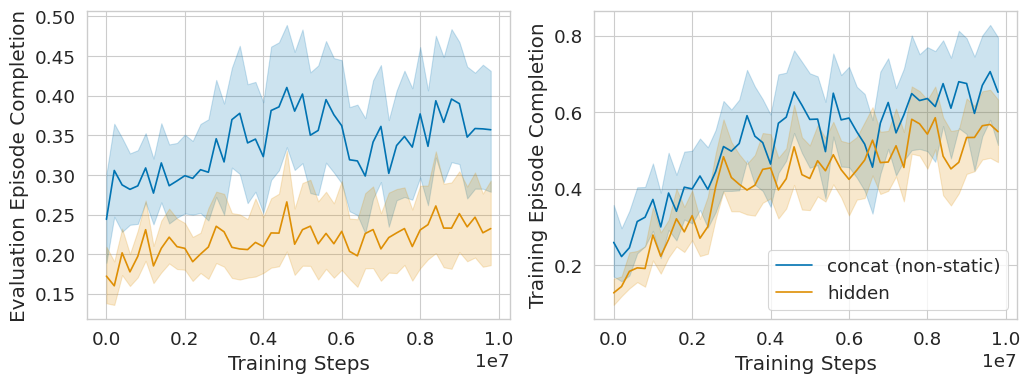

In [23]:
import pandas as pd

df = pd.read_parquet("filtered_runs.parquet")

# Line plot using seaborn of eval_episode_completed vs. train_episode_completed where the hue indicates whether carl.hide_context is True or False
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", font_scale=1.5, context="paper", palette="colorblind")

df['step_quantized'] = pd.qcut(df['step'], 50, labels=False, duplicates="drop")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(
    x=df["step_quantized"] * 10_000_000 // 50, y=df["eval_episode_completed"],
    hue=df["carl.hide_context"], ax=axes[0]
)
axes[0].get_legend().remove()

sns.lineplot(
    x=df["step_quantized"] * 10_000_000 // 50, y=df["train_episode_completed"],
    hue=df["carl.hide_context"], ax=axes[1]
)
axes[0].set_xlabel("Training Steps")
axes[1].set_xlabel("Training Steps")
axes[0].set_ylabel("Evaluation Episode Completion")
axes[1].set_ylabel("Training Episode Completion")

axes[1].get_legend().set_title("")
handles, labels = axes[1].get_legend_handles_labels()
labels = ["concat (non-static)" if l == "False" else "hidden" for l in labels]
axes[1].legend(handles, labels, loc="lower right")
plt.savefig("eval_train_episode_completion.pdf", bbox_inches="tight", dpi=300)
plt.savefig("eval_train_episode_completion.png", bbox_inches="tight", dpi=300)